In [3]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 이미지 전처리
- Fingerprint Image
- Binarization; threshold
- skeletonization

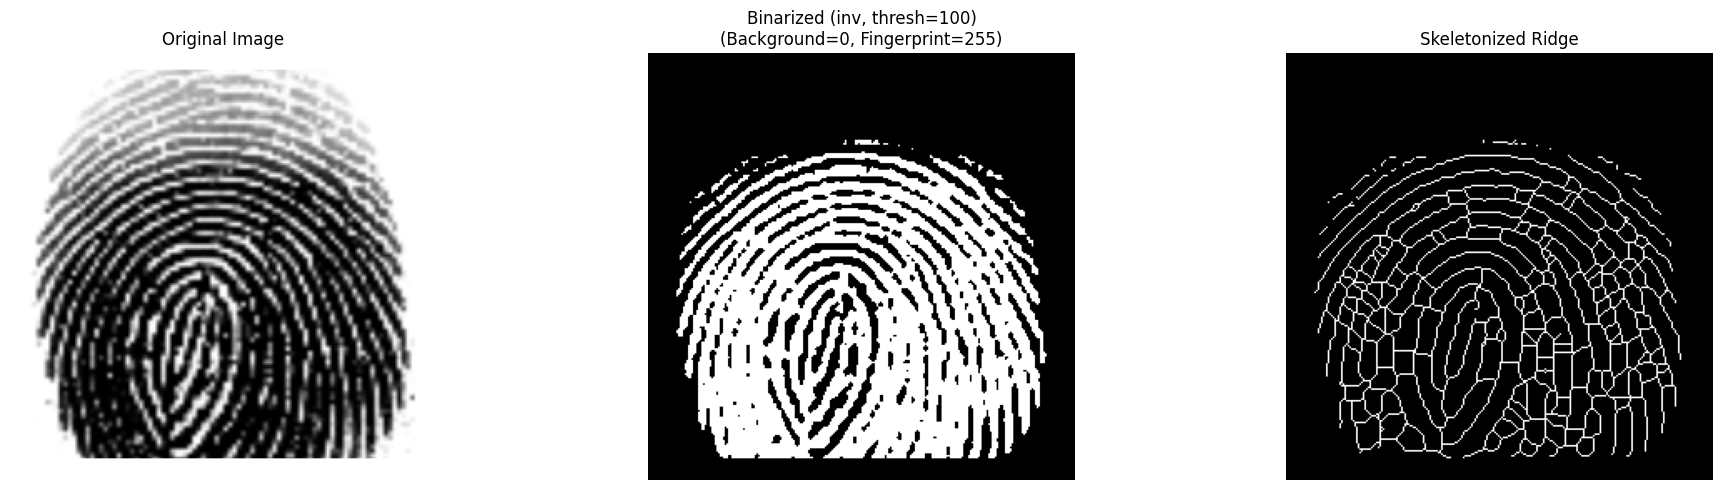

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.segmentation import clear_border

THRESHOLD_VALUE = 100

image_path =  '/content/drive/MyDrive/fingerprint/train_ref/1.BMP'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

_, img_bin = cv2.threshold(img, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY_INV)

img_bin_bool = (img_bin == 255)
img_cleared = clear_border(img_bin_bool)

skeleton = skeletonize(img_cleared)
img_skeleton = (skeleton.astype(np.uint8)) * 255


fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_bin, cmap='gray')
axes[1].set_title(f'Binarized (inv, thresh={THRESHOLD_VALUE})\n(Background=0, Fingerprint=255)')
axes[1].axis('off')

axes[2].imshow(img_skeleton, cmap='gray')
axes[2].set_title('Skeletonized Ridge')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import os
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border

def preprocess_fingerprint(image_path):
    # 그레이스케일 이미지 로드
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
      return None


    THRESHOLD_VALUE = 50
    _, img_bin = cv2.threshold(img,THRESHOLD_VALUE , 255, cv2.THRESH_BINARY_INV)

    # 픽셀값이 255인 부분만 True로 변환하여 boolean 배열 생성
    img_bin_bool = (img_bin == 255)
    img_cleared = clear_border(img_bin_bool)

    # skeletonization 수행
    skeleton = skeletonize(img_cleared)

    # 다시 0~255 범위의 uint8 이미지로 변환
    img_skeleton = (skeleton.astype(np.uint8)) * 255
    return img_skeleton


In [ ]:
# 전처리된 이미지를 폴더에 저장

input_dir = '/content/drive/MyDrive/fingerprint/train_ref'
output_dir = '/content/drive/MyDrive/fingerprint/train_skeletonized'
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
      img_path = os.path.join(input_dir, filename)
      skeleton = preprocess_fingerprint(img_path)
      save_path = os.path.join(output_dir, filename)
      cv2.imwrite(save_path, skeleton)

In [ ]:
import os

# 확인할 디렉터리 경로를 지정합니다.
input_dir  = '/content/drive/MyDrive/fingerprint/train_ref'
output_dir = '/content/drive/MyDrive/fingerprint/train_skeletonized'

# 폴더 내에 있는 .bmp 파일만 세는 함수
def count_bmp_files(directory):
    return sum(
        1
        for fname in os.listdir(directory)
        if fname.lower().endswith('.bmp')
    )

# 개수 계산
num_input  = count_bmp_files(input_dir)
num_output = count_bmp_files(output_dir)

print(f"원본 폴더 ({input_dir})의 BMP 파일 개수: {num_input}")
print(f"전처리된 폴더 ({output_dir})의 BMP 파일 개수: {num_output}")

# 만약 “전처리가 모두 잘 되었는지” 확인하려면 두 값이 같은지 비교
if num_input == num_output:
    print("✅ 모든 BMP 파일이 전처리되어 output_dir에 저장되었습니다.")
else:
    print("⚠️ 입력 파일 개수와 결과 파일 개수가 다릅니다. 전처리가 누락된 파일이 있을 수 있습니다.")

# 2. 특징 추출
1. Minutiae (end, bif) 검출 - 3x3 window 사용
2. 실행시간 분석 후 가능한 경우 속도 향상 시킬 것

## 특징 추출 1 - 기본

In [16]:
# 특징 추출 함수
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def detect_minutiae_from_skeleton(img_skeleton):
    """
    스켈레톤화된 이미지(0/255)에서 3x3 윈도우를 이용해 Endpoint와 Bifurcation 검출
    - img_skeleton: 2D numpy array (uint8), 지문 뼈대 부분만 255, 나머지 0
    반환값:
      endpoints:  [(y1, x1), (y2, x2), ...]
      bifurcations: [(y1, x1), (y2, x2), ...]
    """
    # (1) 미리 패딩을 한 배열을 만들어서 경계 픽셀도 처리할 수 있도록 함
    h, w = img_skeleton.shape
    padded = np.zeros((h+2, w+2), dtype=np.uint8)
    padded[1:h+1, 1:w+1] = img_skeleton

    endpoints = []
    bifurcations = []

    # (2) 3x3 윈도우 순회
    for y in range(1, h+1):
        for x in range(1, w+1):
            if padded[y, x] != 255:
                # 가운데 픽셀이 스켈레톤 뼈대가 아니면 패스
                continue

            # 3x3 이웃 픽셀 중 뼈대(255)인 개수 카운트
            window = padded[y-1:y+2, x-1:x+2]
            # 가운데 픽셀을 제외하고 sum
            neighbor_count = np.sum(window == 255) - 1

            if neighbor_count == 1:
                endpoints.append((y-1, x-1))          # 패딩 보정
            elif neighbor_count == 3:
                bifurcations.append((y-1, x-1))      # 패딩 보정
            # (원칙적으로 2나 4 이상은 Minutiae가 아님)

    return endpoints, bifurcations


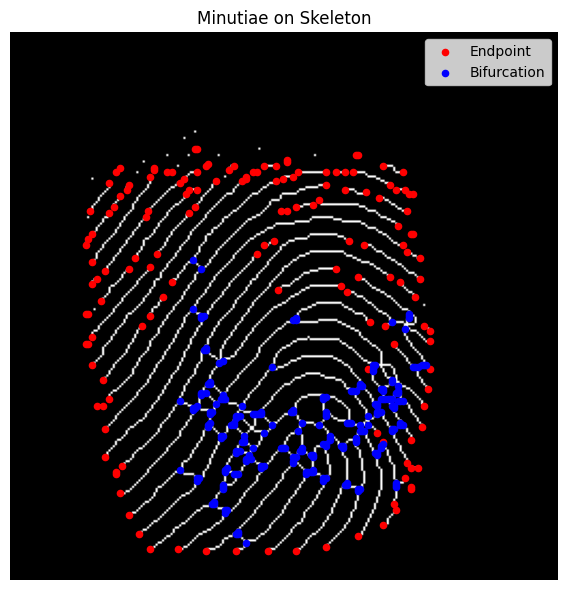

In [17]:
# 특징 추출 예시

img_path = '/content/drive/MyDrive/fingerprint/train_skeletonized/60.BMP'

# 1) 스켈레톤 이미지 로드 (반드시 스켈레톤된 결과)
img_skel = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img_skel is None:
    raise FileNotFoundError(f"Cannot load image at {img_path}")

# 2) Minutiae 검출
endpoints, bifurcations = detect_minutiae_from_skeleton(img_skel)

# 3) Matplotlib으로 표시
plt.figure(figsize=(6,6))

plt.imshow(img_skel, cmap='gray')
plt.title("Minutiae on Skeleton")
plt.axis('off')

# Endpoints(빨간 점) / Bifurcations(푸른 점)
if endpoints:
    ys_end, xs_end = zip(*endpoints)
    plt.scatter(xs_end, ys_end, s=20, c='red', marker='o', label='Endpoint')
if bifurcations:
    ys_bif, xs_bif = zip(*bifurcations)
    plt.scatter(xs_bif, ys_bif, s=20, c='blue', marker='o', label='Bifurcation')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## 특징 추출 2 - Bounding Box

In [18]:
import numpy as np

def get_skeleton_bbox(img_skel_bool, padding=0):
    """
    - img_skel_bool: Boolean 2D 배열, True인 부분만 지문 뼈대
    - padding: Bounding Box 경계 주변에 몇 픽셀 여유를 둘지
    반환: (y_min, y_max, x_min, x_max) 형태의 정수 좌표
    """
    # True인 픽셀 위치들의 (row, col) 좌표 추출
    coords = np.column_stack(np.where(img_skel_bool))
    if coords.size == 0:
        # 만약 전체가 False라면, 원본 크기 전체를 bbox로 삼아버림
        return 0, img_skel_bool.shape[0]-1, 0, img_skel_bool.shape[1]-1

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # padding을 고려하되, 이미지 크기를 넘지 않도록 Clamp
    y_min = max(y_min - padding, 0)
    x_min = max(x_min - padding, 0)
    y_max = min(y_max + padding, img_skel_bool.shape[0] - 1)
    x_max = min(x_max + padding, img_skel_bool.shape[1] - 1)

    return y_min, y_max, x_min, x_max

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_and_detect_minutiae(img_skel, margin=5, padding=5):
    """
    1) img_skel (0/255 uint8)에서 Boolean 형태로 바꿔서 bbox 계산
    2) bbox 영역으로 스켈레톤을 Crop
    3) Crop된 스켈레톤에서 Minutiae 검출
    4) Crop된 영역의 (폭, 높이)를 기준으로, margin 픽셀 이내 Minutiae 걸러냄
    반환:
      cropped_skel,            # (uint8) 잘린 스켈레톤
      endpoints_filt,          # [(y, x), …] Filter 후 Endpoint 좌표 (Crop 좌표계)
      bifurcations_filt,      # [(y, x), …] Filter 후 Bifurcation 좌표 (Crop 좌표계)
      (by, ty, bx, tx)        # 원본 이미지 좌표계에서 bbox: y_min, y_max, x_min, x_max
    """

    # 1) Boolean 배열 만들기
    img_skel_bool = (img_skel == 255)

    # 2) 원본 스켈레톤 전체에서 Bounding Box 계산
    by, ty, bx, tx = get_skeleton_bbox(img_skel_bool, padding=padding)
    # by = y_min, ty = y_max, bx = x_min, tx = x_max

    # 3) 해당 bbox로 스켈레톤 이미지를 Crop (정수 슬라이스)
    cropped_skel = img_skel[by:ty+1, bx:tx+1]
    # cropped_skel은 uint8 형태(0/255), 작은 크기의 스켈레톤

    # 4) Crop된 스켈레톤에서 Minutiae 검출 (기존 함수 재사용)
    endpoints, bifurcations = detect_minutiae_from_skeleton(cropped_skel)

    # 5) Crop된 이미지 크기(높이, 너비)
    h_crop, w_crop = cropped_skel.shape

    # 6) Crop된 좌표들에 대해서, margin 이내인 것만 남기기
    endpoints_filt = [
        (y, x) for (y, x) in endpoints
        if margin <= x < (w_crop - margin) and margin <= y < (h_crop - margin)
    ]
    bifurcations_filt = [
        (y, x) for (y, x) in bifurcations
        if margin <= x < (w_crop - margin) and margin <= y < (h_crop - margin)
    ]

    return cropped_skel, endpoints_filt, bifurcations_filt, (by, ty, bx, tx)

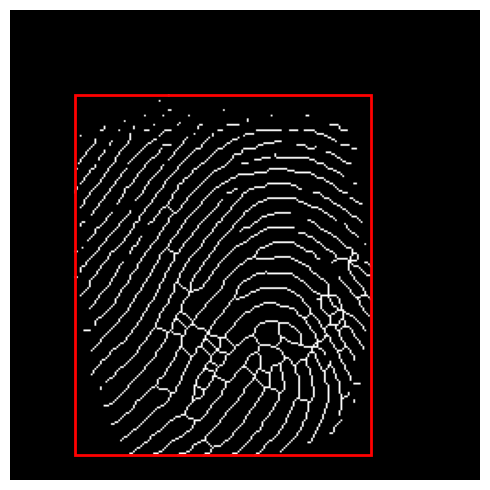

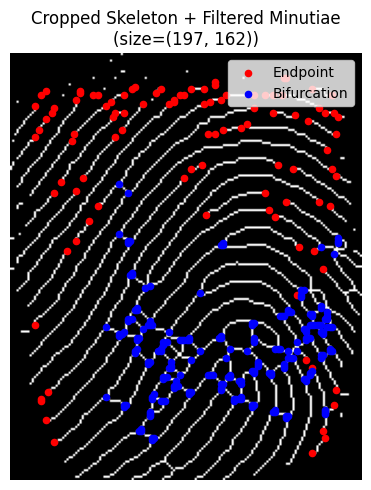

Filtered Endpoints = 103, Filtered Bifurcations = 207


In [20]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# (위에서 정의한 get_skeleton_bbox, detect_minutiae_from_skeleton, crop_and_detect_minutiae 사용)

# 예시 이미지 경로
input_path = '/content/drive/MyDrive/fingerprint/train_skeletonized/77.BMP'

# 1) 전체 스켈레톤 이미지 로드
img_skel_full = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img_skel_full is None:
    raise FileNotFoundError(f"이미지 로드 실패: {img_path}")

# 2) Crop + Minutiae Detection (+ Border Filtering)
margin   = 10  # 크롭된 영역 경계에서 5 픽셀 이내 Minutiae 제거
padding  = 0  # 스켈레톤 bbox 주변에 5 픽셀 여유
cropped_skel, endpoints_filt, bifurcations_filt, bbox_coords = crop_and_detect_minutiae(
    img_skel_full, margin=margin, padding=padding
)

by, ty, bx, tx = bbox_coords  # 원본 좌표계의 (y_min, y_max, x_min, x_max)

# 3) 시각화 ① “전체 스켈레톤 위에 Bounding Box”
plt.figure(figsize=(5,5))
plt.imshow(img_skel_full, cmap='gray')

# 빨간 사각형(ROI 경계)
plt.gca().add_patch(
    plt.Rectangle(
        (bx, by),           # 왼쪽 위 corner (x, y)
        tx - bx,            # width
        ty - by,            # height
        edgecolor='red',
        facecolor='none',
        linewidth=2
    )
)
plt.axis('off')
plt.tight_layout()
plt.show()

# 4) 시각화 ② “Crop된 영역 + 필터링된 Minutiae”
plt.figure(figsize=(5,5))
plt.imshow(cropped_skel, cmap='gray')
plt.title(f"Cropped Skeleton + Filtered Minutiae\n(size={cropped_skel.shape})")
plt.axis('off')

# (a) 필터링된 Endpoint (빨간 점)
if endpoints_filt:
    ys_e, xs_e = zip(*endpoints_filt)
    plt.scatter(xs_e, ys_e, c='red', s=20, marker='o', label='Endpoint')

# (b) 필터링된 Bifurcation (파란 점)
if bifurcations_filt:
    ys_b, xs_b = zip(*bifurcations_filt)
    plt.scatter(xs_b, ys_b, c='blue', s=20, marker='o', label='Bifurcation')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 5) 검출 결과 개수 출력
print( f"Filtered Endpoints = {len(endpoints_filt)}, "
      f"Filtered Bifurcations = {len(bifurcations_filt)}")


## 특징 추출3 - ROI (최종)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes

# --- convex‐hull 기반 ROI 마스크 생성 함수 ---
def get_skeleton_hull_mask(img_skel_bool: np.ndarray):
    pts = np.column_stack(np.where(img_skel_bool))
    if len(pts) < 3:
        return np.zeros_like(img_skel_bool, dtype=np.uint8)
    pts_xy = pts[:, ::-1].astype(np.int32)      # (y,x) → (x,y)
    hull   = cv2.convexHull(pts_xy)
    mask   = np.zeros_like(img_skel_bool, dtype=np.uint8)
    cv2.fillConvexPoly(mask, hull, 255)
    return mask

In [ ]:
# --- minutiae 추출 함수 (이전 정의 재사용) ---
def get_minu_points(img_skeleton: np.ndarray, mask: np.ndarray):
    ske = (img_skeleton > 0).astype(np.uint8)
    m   = (mask         > 0).astype(np.uint8)
    ske_masked = cv2.bitwise_and(ske, m)

    kernel = np.array([[1,1,1],[1,0,1],[1,1,1]], dtype=np.uint8)
    neighbor_count = cv2.filter2D(ske_masked, -1, kernel)

    endpoints    = (ske_masked==1)&(neighbor_count==1)
    bifurcations = (ske_masked==1)&(neighbor_count==3)

    img_term = (endpoints.astype(np.uint8))*255
    img_bif  = (bifurcations.astype(np.uint8))*255

    return img_term, img_bif

In [ ]:
import cv2
import numpy as np

def get_minu_points(img_skeleton: np.ndarray,
                    mask: np.ndarray,
                    min_margin: int = 5):
    """
    Args:
      img_skeleton : uint8 스켈레톤 이미지 (0 또는 255)
      mask         : uint8 ROI 마스크     (0 또는 255)
      min_margin   : boundary에서 최소 이 픽셀만큼 떨어진 minutiae만 남김
    Returns:
      img_term, img_bif: uint8 endpoint/bifurcation 바이너리 이미지 (0 또는 255)
    """
    # 1) skeleton과 mask를 0/1로 변환해 교집합
    ske = (img_skeleton > 0).astype(np.uint8)
    m   = (mask         > 0).astype(np.uint8)
    ske_masked = cv2.bitwise_and(ske, m)

    # 2) 8-이웃 개수 계산용 커널
    kernel = np.array([[1,1,1],
                       [1,0,1],
                       [1,1,1]], dtype=np.uint8)
    neighbor_count = cv2.filter2D(ske_masked, -1, kernel)

    # 3) endpoint(==1), bifurcation(==3) 판별
    endpoints    = (ske_masked == 1) & (neighbor_count == 1)
    bifurcations = (ske_masked == 1) & (neighbor_count == 3)

    # 4) ROI 경계로부터의 거리 계산
    #    mask가 uint8(0/255)이므로, distanceTransform 전 binary화
    mask_bin = (mask > 0).astype(np.uint8) * 255
    dist = cv2.distanceTransform(mask_bin, cv2.DIST_L2, 5)

    # 5) 거리 필터링: 경계에서 min_margin 이상 떨어진 점만 남김
    endpoints    &= (dist > min_margin)
    bifurcations &= (dist > min_margin)

    # 6) 0/1 → 0/255 변환하여 리턴
    img_term = (endpoints.astype(np.uint8)) * 255
    img_bif  = (bifurcations.astype(np.uint8)) * 255

    return img_term, img_bif



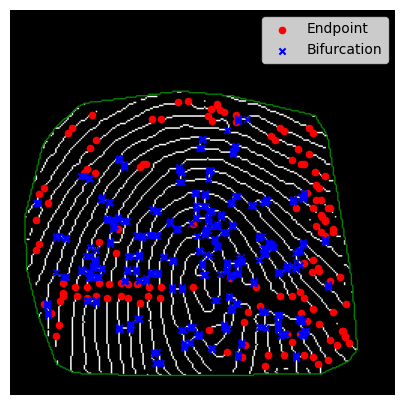

In [ ]:
# 1) BMP 스켈레톤 불러오기
skeleton_path = '/content/drive/MyDrive/fingerprint/train_skeletonized/63.BMP'
img_skel = cv2.imread(skeleton_path, cv2.IMREAD_GRAYSCALE)
if img_skel is None:
    raise FileNotFoundError(f"이미지 로드 실패: {skeleton_path}")

# 2) Boolean 형태 변환
img_skel_bool = (img_skel == 255)

# 3) ROI 마스크 생성 (convex hull)
roi_mask = get_skeleton_hull_mask(img_skel_bool)

# 4) minutiae 검출
img_term, img_bif = get_minu_points(img_skel, roi_mask)

# 5) 결과 시각화
plt.figure(figsize=(5,5))
plt.imshow(img_skel, cmap='gray')
ys, xs = np.where(img_term>0)
plt.scatter(xs, ys, c='red',    s=20, marker='o', label='Endpoint')
ys, xs = np.where(img_bif>0)
plt.scatter(xs, ys, c='blue',   s=20, marker='x', label='Bifurcation')
plt.contour(roi_mask, levels=[127], colors='g', linewidths=1)
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

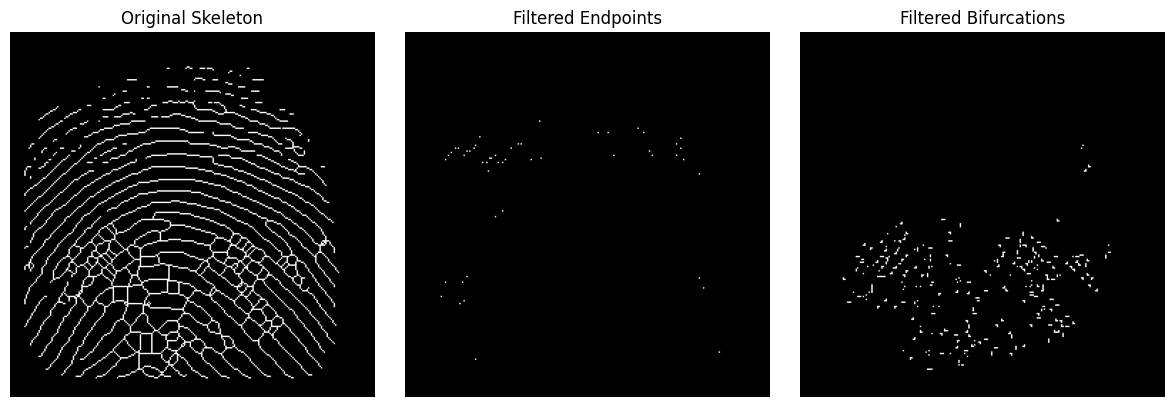

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 세선화된 지문 이미지 (0/255 uint8) 불러오기
img_skel = cv2.imread('/content/drive/MyDrive/fingerprint/train_skeletonized/77.BMP',
                      cv2.IMREAD_GRAYSCALE)

# 1) img_skel이 None이 아닌지 확인
if img_skel is None:
    raise FileNotFoundError("세선화된 BMP 파일을 열 수 없습니다.")


mask = get_skeleton_hull_mask(img_skel == 255)

# 2) get_minu_points_loop 호출
#    margin=5, padding=5 정도를 기본값으로 두고 테스트
img_term, img_bif = get_minu_points(img_skel,roi_mask)

# 3) 결과 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_skel, cmap='gray')
plt.title('Original Skeleton')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_term, cmap='gray')
plt.title('Filtered Endpoints')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_bif, cmap='gray')
plt.title('Filtered Bifurcations')
plt.axis('off')

plt.tight_layout()
plt.show()

### train 특징 폴더에 저장

In [ ]:
%%timeit
import os

# — 폴더 전체 처리 스크립트 —
input_dir        = '/content/drive/MyDrive/fingerprint/train_skeletonized'
output_dir_term  = '/content/drive/MyDrive/fingerprint/again_features/endpoints'
output_dir_bif   = '/content/drive/MyDrive/fingerprint/again_features/bifurcations'
os.makedirs(output_dir_term, exist_ok=True)
os.makedirs(output_dir_bif,  exist_ok=True)

# 처리할 margin (경계로부터 최소 거리)
MIN_MARGIN = 5

for fname in os.listdir(input_dir):
    if not fname.lower().endswith('.bmp'):
        continue

    # 1) 스켈레톤 BMP 로드
    path_in = os.path.join(input_dir, fname)
    img_skel = cv2.imread(path_in, cv2.IMREAD_GRAYSCALE)
    if img_skel is None:
        print(f"⚠️ 로드 실패: {fname}")
        continue

    # 2) ROI 마스크 생성 (hull)
    mask = get_skeleton_hull_mask(img_skel == 255)

    # 3) minutiae 검출
    img_term, img_bif = get_minu_points(img_skel, mask, min_margin=MIN_MARGIN)

    # 4) 결과 저장
    cv2.imwrite(os.path.join(output_dir_term, fname), img_term)
    cv2.imwrite(os.path.join(output_dir_bif,  fname), img_bif)

15.5 s ± 377 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import os

# 처리 전 입력 파일 개수
input_dir       = '/content/drive/MyDrive/fingerprint/train_skeletonized'
input_files     = [f for f in os.listdir(input_dir) if f.lower().endswith('.bmp')]
num_input       = len(input_files)

# 처리 후 출력 파일 개수
output_dir_term = '/content/drive/MyDrive/fingerprint/again_features/endpoints'
output_dir_bif  = '/content/drive/MyDrive/fingerprint/again_features/bifurcations'
term_files      = [f for f in os.listdir(output_dir_term) if f.lower().endswith('.bmp')]
bif_files       = [f for f in os.listdir(output_dir_bif)  if f.lower().endswith('.bmp')]
num_term        = len(term_files)
num_bif         = len(bif_files)

print(f"입력 이미지:    {num_input} files")
print(f"Endpoint 파일: {num_term} files")
print(f"Bifurcation 파일: {num_bif} files")

# 기대하는 개수(예: 입력 파일 수와 동일)와 비교
if num_term == num_input and num_bif == num_input:
    print("✅ 모든 파일이 정상적으로 처리되어 개수가 일치합니다.")
else:
    print("⚠️ 파일 개수가 일치하지 않습니다. 누락 또는 중복된 파일이 있는지 확인하세요.")


입력 이미지:    477 files
Endpoint 파일: 477 files
Bifurcation 파일: 477 files
✅ 모든 파일이 정상적으로 처리되어 개수가 일치합니다.


## Test2 특징추출

In [ ]:
import os

# — 폴더 전체 처리 스크립트 —
input_dir        = '/content/drive/MyDrive/fingerprint/test2_skeletonized'
output_dir_term  = '/content/drive/MyDrive/fingerprint/again_features/test2_endpoints'
output_dir_bif   = '/content/drive/MyDrive/fingerprint/again_features/test2_bifurcations'
os.makedirs(output_dir_term, exist_ok=True)
os.makedirs(output_dir_bif,  exist_ok=True)

# 처리할 margin (경계로부터 최소 거리)
MIN_MARGIN = 5

for fname in os.listdir(input_dir):
    if not fname.lower().endswith('.bmp'):
        continue

    # 1) 스켈레톤 BMP 로드
    path_in = os.path.join(input_dir, fname)
    img_skel = cv2.imread(path_in, cv2.IMREAD_GRAYSCALE)
    if img_skel is None:
        print(f"⚠️ 로드 실패: {fname}")
        continue

    # 2) ROI 마스크 생성 (hull)
    mask = get_skeleton_hull_mask(img_skel == 255)

    # 3) minutiae 검출
    img_term, img_bif = get_minu_points(img_skel, mask, min_margin=MIN_MARGIN)

    # 4) 결과 저장
    cv2.imwrite(os.path.join(output_dir_term, fname), img_term)
    cv2.imwrite(os.path.join(output_dir_bif,  fname), img_bif)

In [ ]:
import os

# 처리 전 입력 파일 개수
input_dir       = '/content/drive/MyDrive/fingerprint/test2_skeletonized'
input_files     = [f for f in os.listdir(input_dir) if f.lower().endswith('.bmp')]
num_input       = len(input_files)

# 처리 후 출력 파일 개수
output_dir_term = '/content/drive/MyDrive/fingerprint/again_features/test2_endpoints'
output_dir_bif  = '/content/drive/MyDrive/fingerprint/again_features/test2_bifurcations'
term_files      = [f for f in os.listdir(output_dir_term) if f.lower().endswith('.bmp')]
bif_files       = [f for f in os.listdir(output_dir_bif)  if f.lower().endswith('.bmp')]
num_term        = len(term_files)
num_bif         = len(bif_files)

print(f"입력 이미지:    {num_input} files")
print(f"Endpoint 파일: {num_term} files")
print(f"Bifurcation 파일: {num_bif} files")

# 기대하는 개수(예: 입력 파일 수와 동일)와 비교
if num_term == num_input and num_bif == num_input:
    print("✅ 모든 파일이 정상적으로 처리되어 개수가 일치합니다.")
else:
    print("⚠️ 파일 개수가 일치하지 않습니다. 누락 또는 중복된 파일이 있는지 확인하세요.")

입력 이미지:    1428 files
Endpoint 파일: 1428 files
Bifurcation 파일: 1428 files
✅ 모든 파일이 정상적으로 처리되어 개수가 일치합니다.


#3. Test2 매칭하기

In [ ]:
import os
import cv2
import numpy as np
from scipy.spatial import cKDTree
import csv

def load_minutiae_points(endp_path: str, bif_path: str):
    """
    endpoint·bifurcation 바이너리 맵에서 (y,x) 좌표 추출 후 합쳐서 리턴
    """
    pts = []
    # endpoint
    img_e = cv2.imread(endp_path, cv2.IMREAD_GRAYSCALE)
    if img_e is not None:
        ys, xs = np.where(img_e > 0)
        pts.extend(zip(ys, xs))
    # bifurcation
    img_b = cv2.imread(bif_path, cv2.IMREAD_GRAYSCALE)
    if img_b is not None:
        ys, xs = np.where(img_b > 0)
        pts.extend(zip(ys, xs))
    return np.array(pts, dtype=np.float32)  # shape (N,2)

def match_test_to_train(train_ep_dir, train_bf_dir,
                        test_ep_dir,  test_bf_dir,
                        file_ext='.bmp'):
    # 1) train 파일 목록 & 포인트셋/트리 생성
    train_files = [f for f in os.listdir(train_ep_dir)
                   if f.lower().endswith(file_ext)]
    train_trees = {}
    for fname in train_files:
        p_ep = os.path.join(train_ep_dir, fname)
        p_bf = os.path.join(train_bf_dir, fname)
        pts  = load_minutiae_points(p_ep, p_bf)
        if pts.size == 0:
            continue
        tree = cKDTree(pts)
        train_trees[fname] = tree

    # 2) test 파일마다 최적 매칭 탐색
    results = []
    test_files = [f for f in os.listdir(test_ep_dir)
                  if f.lower().endswith(file_ext)]
    for tf in sorted(test_files):
        p_ep = os.path.join(test_ep_dir, tf)
        p_bf = os.path.join(test_bf_dir, tf)
        test_pts = load_minutiae_points(p_ep, p_bf)
        if test_pts.size == 0:
            print(f"⚠️ Test minutiae 없음: {tf}")
            continue

        best_score = float('inf')
        best_train = None
        # 각 train 트리와 비교
        for train_name, tree in train_trees.items():
            # 각 test 포인트의 최근접 train 포인트 거리
            dists, _ = tree.query(test_pts, k=1)
            score = dists.mean()
            if score < best_score:
                best_score, best_train = score, train_name

        results.append((tf, best_train, best_score))
        print(f"{tf} → Best Match: {best_train}, Avg-NN Dist = {best_score:.2f}")

    return results

# — 사용 예시 —
train_endpoint_dir = '/content/drive/MyDrive/fingerprint/again_features/endpoints'
train_bifurc_dir   = '/content/drive/MyDrive/fingerprint/again_features/bifurcations'
test_endpoint_dir  = '/content/drive/MyDrive/fingerprint/again_features/test2_endpoints'
test_bifurc_dir    = '/content/drive/MyDrive/fingerprint/again_features/test2_bifurcations'

match_results = match_test_to_train(
    train_endpoint_dir, train_bifurc_dir,
    test_endpoint_dir,  test_bifurc_dir,
    file_ext='.bmp'
)

# 2) CSV로 저장
output_csv = '/content/drive/MyDrive/fingerprint/again_features/match_results1.csv'
os.makedirs(os.path.dirname(output_csv), exist_ok=True)

with open(output_csv, 'w', newline='', encoding='utf-8') as wf:
    writer = csv.writer(wf)
    # 헤더
    writer.writerow(['test_file', 'best_train_file', 'avg_nn_distance'])
    # 데이터
    for row in match_results:
        writer.writerow(row)

print(f"\n✅ Saved results to {output_csv}")

In [ ]:
import os
import pandas as pd
import numpy as np

csv_path = '/content/drive/MyDrive/fingerprint/again_features/match_results1.csv'
df = pd.read_csv(csv_path)

# 거리 컬럼 숫자로 변환
df['distance'] = pd.to_numeric(df['avg_nn_distance'], errors='coerce')
df = df.dropna(subset=['distance']).reset_index(drop=True)

# test_file 에서 ID만 추출: "_" 앞부분
df['test_id']  = df['test_file'].apply(lambda x: os.path.splitext(x)[0].split('_')[0])
df['train_id'] = df['best_train_file'].apply(lambda x: os.path.splitext(x)[0])

# 이제 genuine 여부 제대로 판정
df['true_match'] = (df['test_id'] == df['train_id'])

# genuine/impostor 개수 확인
n_pos = df['true_match'].sum()
n_neg = len(df) - n_pos
print(f"genuine 샘플: {n_pos}, impostor 샘플: {n_neg}")

# EER 계산 (브루트포스 스캔)
thresholds = np.sort(df['distance'].unique())
best_diff = np.inf; eer = None; thr_eer = None

for thr in thresholds:
    preds = df['distance'] <= thr
    TP = int(((df['true_match']==True ) &  preds).sum())
    FN = int(((df['true_match']==True ) & ~preds).sum())
    FP = int(((df['true_match']==False) &  preds).sum())
    TN = int(((df['true_match']==False) & ~preds).sum())
    if (FP+TN)==0 or (TP+FN)==0: continue
    far = FP/(FP+TN)
    frr = FN/(TP+FN)
    diff = abs(far - frr)
    if diff < best_diff:
        best_diff = diff
        eer      = (far+frr)/2
        thr_eer  = thr

print(f"\n=== EER ===\nEER = {eer:.4f}, Threshold = {thr_eer:.2f}")


genuine 샘플: 602, impostor 샘플: 769

=== EER ===
EER = 0.1896, Threshold = 3.22


#4. Test2 Metric

In [ ]:
import os
import pandas as pd

# 1) 설정
csv_path  = '/content/drive/MyDrive/fingerprint/again_features/match_results1.csv'
threshold = 3.22  # Avg-NN Distance ≤ threshold → accept

# 2) CSV 로드 & 거리 컬럼 정리
df = pd.read_csv(csv_path)
df['distance'] = pd.to_numeric(df['avg_nn_distance'], errors='coerce')
df = df.dropna(subset=['distance']).reset_index(drop=True)

# 3) ID 추출
#    test_file: '100_type3.BMP' → test_id='100'
df['test_id']  = df['test_file'].apply(lambda x: os.path.splitext(x)[0].split('_')[0])
#    best_train_file: '100.BMP' → train_id='100'
df['train_id'] = df['best_train_file'].apply(lambda x: os.path.splitext(x)[0])

# 4) ground-truth, 예측 (accept/reject)
df['true_match'] = df['test_id'] == df['train_id']
df['pred_accept'] = df['distance'] <= threshold

# 5) confusion matrix
TP = len(df[(df['true_match'] == True ) & (df['pred_accept'] == True )])
FN = len(df[(df['true_match'] == True ) & (df['pred_accept'] == False)])
FP = len(df[(df['true_match'] == False) & (df['pred_accept'] == True )])
TN = len(df[(df['true_match'] == False) & (df['pred_accept'] == False)])

# 6) metrics 계산
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
far       = FP / (FP + TN) if (FP + TN) > 0 else 0.0   # False Accept Rate
frr       = FN / (TP + FN) if (TP + FN) > 0 else 0.0  # False Reject Rate
acc       = (TP + TN) / (TP + TN + FP + FN)

# 7) 결과 출력
print("=== Matching Metrics ===")
print(f"Threshold       = {threshold:.2f}")
print(f"Test files total= {len(df)}")
print(f"TP = {TP}, FP = {FP}, FN = {FN}, TN = {TN}")
print(f"Precision       = {precision:.4f}")
print(f"Recall          = {recall:.4f}")
print(f"FAR             = {far:.4f}")
print(f"FRR             = {frr:.4f}")
print(f"Accuracy        = {acc:.4f}")



=== Matching Metrics ===
Threshold       = 3.22
Test files total= 1371
TP = 488, FP = 144, FN = 114, TN = 625
Precision       = 0.7722
Recall          = 0.8106
FAR             = 0.1873
FRR             = 0.1894
Accuracy        = 0.8118


## 5. Test1 매칭

In [2]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import glob
import cv2
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Dataset: generates (original, transformed) pairs with random rotation+translation
class FingerprintPoseDataset(Dataset):
    def __init__(self, img_folder, max_rot=30, max_tr=20):
        self.paths = glob.glob(os.path.join(img_folder, '*.BMP'))
        self.max_rot = max_rot
        self.max_tr = max_tr

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        h, w = img.shape

        theta = np.random.uniform(-self.max_rot, self.max_rot)
        tx = np.random.uniform(-self.max_tr, self.max_tr)
        ty = np.random.uniform(-self.max_tr, self.max_tr)

        M = cv2.getRotationMatrix2D((w/2, h/2), theta, 1.0)
        M[:,2] += [tx, ty]
        img_t = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=0)

        pair = np.stack([img, img_t], axis=0).astype(np.float32)  # (2, H, W)
        label = np.array([theta, tx, ty], dtype=np.float32)
        return torch.from_numpy(pair), torch.from_numpy(label)

# Model: uses adaptive pooling to avoid hardcoding h, w
class PoseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 16, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x

# Training function
def train_pose_net(img_folder, epochs=20, batch_size=16, lr=1e-3, device='cuda'):
    dataset = FingerprintPoseDataset(img_folder)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    model = PoseNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
        avg_loss = total_loss / len(dataset)
        print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

    return model

# Inference helper
def infer_pose(model, ref_img, qry_img, device='cuda'):
    ref = ref_img.astype(np.float32) / 255.0
    qry = qry_img.astype(np.float32) / 255.0
    inp = np.stack([ref, qry], axis=0)[None,...]
    inp = torch.from_numpy(inp).to(device)
    model.eval()
    with torch.no_grad():
        theta, tx, ty = model(inp).cpu().numpy()[0]
    print('pred rot angles:', theta)
    print('pred tr vector:', (tx, ty))

In [2]:
# 1) 경로 설정
TRAIN_SKELETON_FOLDER = '/content/drive/MyDrive/fingerprint/train_ref'
TEST_SKELETON_FOLDER  = '/content/drive/MyDrive/fingerprint/test'
EPOCHS     = 50
BATCH_SIZE = 16
LR         = 1e-3

# 2) GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 3) 모델 학습
model = train_pose_net(
    img_folder=TRAIN_SKELETON_FOLDER,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR
)
model = model.to(device)

# 4) Test 폴더 내 모든 이미지 쌍에 대해 예측
#    (원본 트레인 이미지는 파일명에서 ID만 뽑아서 매칭)
test_paths = sorted(glob.glob(os.path.join(TEST_SKELETON_FOLDER, '*.BMP')))
for test_path in test_paths:
    # 파일명에서 ID 뽑기 (예: '17_type1.BMP' → '17.BMP')
    fname = os.path.basename(test_path)
    base = os.path.splitext(fname)[0].split('_')[0] + '.BMP'
    ref_path = os.path.join(TRAIN_SKELETON_FOLDER, base)
    if not os.path.isfile(ref_path):
        print(f"⚠️ 원본 Train 스켈레톤이 없습니다: {base}")
        continue

    # 이미지 로드 & 정규화
    ref = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    qry = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    h, w = ref.shape

    # CNN 입력용 텐서 생성
    inp = np.stack([ref, qry], axis=0)[None]   # shape (1,2,H,W)
    inp = torch.from_numpy(inp).to(device)

    # 예측
    model.eval()
    with torch.no_grad():
        theta, tx, ty = model(inp).cpu().numpy()[0]

    print(f"Test: {fname}  →  Train: {base}")
    print(f"  pred rot angles: {theta:.2f}°")
    print(f"  pred tr vector:  ({tx:.1f}, {ty:.1f})\n")

Using device: cuda
Epoch 1/50 - Loss: 190.2959
Epoch 2/50 - Loss: 188.0554
Epoch 3/50 - Loss: 189.1284
Epoch 4/50 - Loss: 186.5912
Epoch 5/50 - Loss: 186.5595
Epoch 6/50 - Loss: 180.0445
Epoch 7/50 - Loss: 190.9703
Epoch 8/50 - Loss: 184.6688
Epoch 9/50 - Loss: 181.9935
Epoch 10/50 - Loss: 178.8514
Epoch 11/50 - Loss: 149.6024
Epoch 12/50 - Loss: 143.6240
Epoch 13/50 - Loss: 119.3881
Epoch 14/50 - Loss: 107.1744
Epoch 15/50 - Loss: 119.1663
Epoch 16/50 - Loss: 113.3713
Epoch 17/50 - Loss: 110.1448
Epoch 18/50 - Loss: 108.7853
Epoch 19/50 - Loss: 103.9033
Epoch 20/50 - Loss: 102.0297
Epoch 21/50 - Loss: 101.7537
Epoch 22/50 - Loss: 99.6958
Epoch 23/50 - Loss: 101.2172
Epoch 24/50 - Loss: 97.3289
Epoch 25/50 - Loss: 100.4596
Epoch 26/50 - Loss: 93.8232
Epoch 27/50 - Loss: 93.1800
Epoch 28/50 - Loss: 91.6338
Epoch 29/50 - Loss: 82.6065
Epoch 30/50 - Loss: 84.9865
Epoch 31/50 - Loss: 74.9550
Epoch 32/50 - Loss: 61.4899
Epoch 33/50 - Loss: 56.9990
Epoch 34/50 - Loss: 56.0064
Epoch 35/50 - L

In [ ]:

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 3) 파일 목록
train_paths = sorted(glob.glob(os.path.join(TRAIN_SKELETON_FOLDER, '*.BMP')))
test_paths  = sorted(glob.glob(os.path.join(TEST_SKELETON_FOLDER,  '*.BMP')))

results = []

# 4) 모든 Test 이미지에 대해
for test_path in test_paths:
    test_name = os.path.basename(test_path)
    # 테스트 이미지 로드 & 정규화
    test_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    h, w = test_img.shape

    best_iou = -1
    best_train = None
    best_theta = best_tx = best_ty = None

    # 5) 모든 Train 이미지와 비교
    for train_path in train_paths:
        train_name = os.path.basename(train_path)
        train_img = cv2.imread(train_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

        # CNN 입력 텐서 준비
        pair = np.stack([train_img, test_img], axis=0)[None]   # (1,2,H,W)
        inp = torch.from_numpy(pair).to(DEVICE)

        # 6) 회전/이동 예측
        with torch.no_grad():
            theta, tx, ty = model(inp).cpu().numpy()[0]

        # 7) Train 이미지 warp
        M = cv2.getRotationMatrix2D((w/2, h/2), theta, 1.0)
        M[:,2] += [tx, ty]
        warped = cv2.warpAffine((train_img*255).astype(np.uint8), M, (w, h),
                                flags=cv2.INTER_NEAREST, borderValue=0)

        # 8) IoU 계산 (binary skeleton 기준)
        bin_warp = warped > 128
        bin_test = test_img > 0.5
        inter = np.logical_and(bin_warp, bin_test).sum()
        union = np.logical_or(bin_warp, bin_test).sum()
        iou = inter / union if union > 0 else 0.0

        # 9) 최고 IoU 갱신
        if iou > best_iou:
            best_iou = iou
            best_train = train_name
            best_theta = theta
            best_tx = tx
            best_ty = ty

    results.append([
        test_name,
        best_train,
        f"{best_iou:.4f}",
        f"{best_theta:.2f}",
        f"{best_tx:.1f}",
        f"{best_ty:.1f}"
    ])

In [6]:
import csv
csv_path = '/content/drive/MyDrive/fingerprint/test1_iou_results.csv'
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
with open(csv_path, 'w', newline='') as wf:
    writer = csv.writer(wf)
    writer.writerow(['test_file','best_train_file','best_iou',
                     'pred_theta_deg','pred_tx','pred_ty'])
    writer.writerows(results)

print(f"✅ Saved IoU matching results to {csv_path}")

✅ Saved IoU matching results to /content/drive/MyDrive/fingerprint/test1_iou_results.csv


# 6. Test1 Metric

In [8]:
import os
import pandas as pd
import numpy as np

# 1) 결과 CSV 로드
csv_path = '/content/drive/MyDrive/fingerprint/test1_iou_results.csv'
df = pd.read_csv(csv_path)

# 2) ID 추출 (확장자·suffix 제거)
df['test_id'] = df['test_file'].apply(lambda x: os.path.splitext(x)[0])
df['train_id'] = df['best_train_file'].str.replace('.BMP','', case=False)

# 3) ground-truth 라벨
df['true_match'] = df['test_id'] == df['train_id']

# 4) candidate thresholds: 모든 고유 IoU 값
ths = np.sort(df['best_iou'].unique())

best_acc     = -1.0
best_thr_acc = None

best_eer     = None
best_thr_eer = None
min_diff     = np.inf

# 5) 브루트포스 스캔
for thr in ths:
    # accept if IoU ≥ thr
    df['pred_accept'] = df['best_iou'] >= thr

    # confusion
    TP = int(((df.true_match) & (df.pred_accept)).sum())
    FN = int(((df.true_match) & (~df.pred_accept)).sum())
    FP = int((~df.true_match & df.pred_accept).sum())
    TN = int((~df.true_match & ~df.pred_accept).sum())

    # skip invalid
    if (TP+FN)==0 or (FP+TN)==0:
        continue

    # metrics
    acc   = (TP+TN)/(TP+TN+FP+FN)
    far   = FP / (FP + TN)   # False Accept Rate
    frr   = FN / (TP + FN)   # False Reject Rate

    # ① Accuracy 최적 threshold
    if acc > best_acc:
        best_acc     = acc
        best_thr_acc = thr

    # ② EER threshold (|FAR−FRR| 최소)
    diff = abs(far - frr)
    if diff < min_diff:
        min_diff     = diff
        best_eer     = (far + frr)/2
        best_thr_eer = thr

# 6) 결과 출력
print("=== Threshold Search Results ===")
print(f"> Max Accuracy: {best_acc:.4f} at IoU ≥ {best_thr_acc:.4f}")
print(f"> EER = {best_eer:.4f} at IoU = {best_thr_eer:.4f} (FAR≈FRR)")


=== Threshold Search Results ===
> Max Accuracy: 0.8826 at IoU ≥ 0.8847
> EER = 0.3333 at IoU = 0.6852 (FAR≈FRR)


In [13]:
import os
import pandas as pd

# 1) 설정: CSV 경로와 IoU 임계값
csv_path  = '/content/drive/MyDrive/fingerprint/test1_iou_results.csv'
iou_thr   = 0.6852 # IoU ≥ 0.7 이면 “accept”라 간주

# 2) CSV 로드
df = pd.read_csv(csv_path)

# 3) ID 추출
#    test_file: '100.BMP' → test_id='100'
df['test_id']  = df['test_file'].str.replace('.BMP','', case=False)
#    best_train_file: '100.BMP' → train_id='100'
df['train_id'] = df['best_train_file'].str.replace('.BMP','', case=False)

# 4) ground-truth / 예측
df['true_match']  = df['test_id'] == df['train_id']
df['pred_accept'] = df['best_iou'] >= iou_thr

# 5) confusion matrix 계산
TP = len(df[(df.true_match) & (df.pred_accept)])
FN = len(df[(df.true_match) & (~df.pred_accept)])
FP = len(df[(~df.true_match) & (df.pred_accept)])
TN = len(df[(~df.true_match) & (~df.pred_accept)])

# 6) 지표 계산
precision = TP / (TP + FP) if TP+FP>0 else 0.0
recall    = TP / (TP + FN) if TP+FN>0 else 0.0
far       = FP / (FP + TN) if FP+TN>0 else 0.0  # False Accept Rate
frr       = FN / (TP + FN) if TP+FN>0 else 0.0 # False Reject Rate
acc       = (TP + TN) / (TP + TN + FP + FN)

# 7) 결과 출력
print("=== IoU Matching Metrics ===")
print(f"IoU Threshold      = {iou_thr:.2f}")
print(f"TP = {TP}, FP = {FP}, FN = {FN}, TN = {TN}")
print(f"Precision = {precision:.4f}")
print(f"Recall    = {recall:.4f}")
print(f"FAR       = {far:.4f}")
print(f"FRR       = {frr:.4f}")
print(f"Accuracy  = {acc:.4f}")


=== IoU Matching Metrics ===
IoU Threshold      = 0.69
TP = 38, FP = 140, FN = 19, TN = 280
Precision = 0.2135
Recall    = 0.6667
FAR       = 0.3333
FRR       = 0.3333
Accuracy  = 0.6667


In [14]:
import os
import pandas as pd
import numpy as np

# 1) 결과 CSV 로드
csv_path = '/content/drive/MyDrive/fingerprint/test1_iou_results.csv'
df = pd.read_csv(csv_path)

# 2) ID 추출
df['test_id']  = df['test_file'].str.replace('.BMP','', case=False)
df['train_id'] = df['best_train_file'].str.replace('.BMP','', case=False)

# 3) ground-truth 라벨
df['true_match'] = df['test_id'] == df['train_id']

# 4) candidate thresholds: 모든 고유 IoU 값
ths = np.sort(df['best_iou'].unique())

best_acc     = -1.0
best_thr_acc = None

best_eer     = None
best_thr_eer = None
min_diff     = np.inf

# 5) 브루트포스 스캔
for thr in ths:
    df['pred_accept'] = df['best_iou'] >= thr

    TP = int(((df.true_match) & (df.pred_accept)).sum())
    FN = int(((df.true_match) & (~df.pred_accept)).sum())
    FP = int((~df.true_match & df.pred_accept).sum())
    TN = int((~df.true_match & ~df.pred_accept).sum())

    if (TP+FN)==0 or (FP+TN)==0:
        continue

    acc = (TP+TN)/(TP+TN+FP+FN)
    far = FP/(FP+TN)
    frr = FN/(TP+FN)
    diff = abs(far - frr)

    if acc > best_acc:
        best_acc     = acc
        best_thr_acc = thr

    if diff < min_diff:
        min_diff     = diff
        best_eer     = (far + frr)/2
        best_thr_eer = thr

# 6) 결과 출력 (None 체크 포함)
print("=== Threshold Search Results ===")
if best_thr_acc is not None:
    print(f"> Max Accuracy: {best_acc:.4f} at IoU ≥ {best_thr_acc:.4f}")
else:
    print("> Max Accuracy: 계산할 수 있는 유효한 threshold가 없습니다.")

if best_thr_eer is not None:
    print(f"> EER = {best_eer:.4f} at IoU = {best_thr_eer:.4f} (FAR≈FRR)")
else:
    print("> EER: 계산할 수 있는 유효한 threshold가 없습니다.")


=== Threshold Search Results ===
> Max Accuracy: 0.8826 at IoU ≥ 0.8847
> EER = 0.3333 at IoU = 0.6852 (FAR≈FRR)
